In [1]:
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

from stalp import STALPNet
from stalp.lib.vgg_perceptual_loss import VGGPerceptualLoss

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# mean and std of ImageNet to use pre-trained VGG
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
denormalize = transforms.Normalize(
    mean=[-mean / std for mean, std in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std=[1 / std for std in IMAGENET_STD],
)


In [3]:
IMAGE_EXT = tuple(f".{ext}" for ext in "png jpg jpeg bmp".split())


def get_image_paths(dir_path: str):
    paths = []
    for entry in os.scandir(dir_path):
        if not entry.is_file():
            continue
        name = entry.name.lower()
        if any(name.endswith(ext) for ext in IMAGE_EXT):
            paths.append(entry.path)

    return paths


class KeyframesDataset(Dataset):
    def __init__(self, paired_paths: list[tuple[str, str]], transform) -> None:
        super().__init__()
        self.pairs = paired_paths
        self.transform = transform

    def __repr__(self) -> str:
        return f"<KeyframesDataset: {len(self)} path pairs>"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index: int):
        pair_paths = self.pairs[index]
        x = Image.open(pair_paths[0]).convert("RGB")
        y = Image.open(pair_paths[1]).convert("RGB")
        return (self.transform(x), self.transform(y))


class UnpairedDataset(Dataset):
    def __init__(self, unpaired_paths: list[str], transform) -> None:
        super().__init__()
        self.paths = unpaired_paths
        self.transform = transform

    def __repr__(self) -> str:
        return f"<UnpairedDataset: {len(self)} paths>"

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int):
        path = self.paths[index]
        img = Image.open(path).convert("RGB")
        return self.transform(img)


def load_ebsynth_dataset(video_frames_dir: str, keyframes_dir: str):
    keyframes: list[tuple[str, str]] = []
    unpaired: list[str] = []

    for entry in os.scandir(video_frames_dir):
        # skip if non-file
        if not entry.is_file():
            continue

        # skip if non-image
        name = entry.name.lower()
        if not any(name.endswith(ext) for ext in IMAGE_EXT):
            continue

        # check if image is in keyframes folder
        stylised_path = os.path.join(keyframes_dir, name)
        if os.path.exists(stylised_path):
            # image is indeed in keyframes, this is a keyframe pair
            keyframes.append((entry.path, stylised_path))
            # also add to unpaired
            unpaired.append(entry.path)
        else:
            # not in keyframes, this is unpaired
            unpaired.append(entry.path)

    key_dataset = KeyframesDataset(keyframes, transforms.Compose([transforms.ToTensor(), normalize]))
    frm_dataset = UnpairedDataset(unpaired, transforms.Compose([transforms.ToTensor(), normalize]))

    if len(key_dataset) == 0:
        raise FileNotFoundError("No keyframes found")
    if len(frm_dataset) == 0:
        raise FileNotFoundError("No unpaired images found")

    return key_dataset, frm_dataset


# load_ebsynth_dataset(
#     R"C:\Programs\EbSynth-Beta-Win\SampleProject\video",
#     R"C:\Programs\EbSynth-Beta-Win\SampleProject\keys",
#     # transforms.Compose([transforms.ToTensor(), normalize, lambda x: x.to(dev)]),
# )


In [4]:
# key_ds, vid_ds = load_ebsynth_dataset(
#     R"C:\Programs\EbSynth-Beta-Win\SampleProject\video",
#     R"C:\Programs\EbSynth-Beta-Win\SampleProject\keys",
#     # transforms.Compose([transforms.ToTensor(), normalize, lambda x: x.to(dev)]),
# )
# key_loader = DataLoader(key_ds, batch_size=8, shuffle=True)
# frm_loader = DataLoader(vid_ds, batch_size=8, shuffle=True)
# for x, y in iter(key_loader):
#     print("outer")
#     x, y = x.to(dev), y.to(dev)
#     break

#     # for frame in iter(frm_loader):
#     #     print("  sub iter")
#     #     frame = frame.to(dev)
#     #     # print(f"    {frame.shape = }")
#     #     # frame_hat = net(frame)
#     #     # unpaired_loss += vgg_loss(frame_hat, y)

# net = STALPNet().to(dev)
# net(x)

In [5]:
# torch.cuda.memory_allocated() / 1000 / 1000

Stopping training...


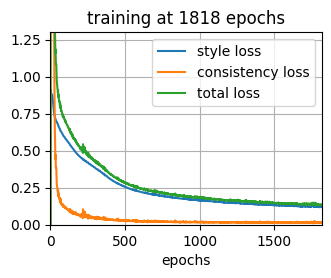

In [7]:
class TrainingVisualiser:
    def __init__(
        self,
        data: list[tuple],
        headers: list[str] | None = None,
        xlim: tuple[str, str] | None = None,
        ylim: tuple[str, str] | None = None,
        min_xrange: int = 10,
        figsize=(3.5, 2.5),
    ) -> None:
        from matplotlib import pyplot as plt

        self.data = data
        self.headers = headers
        self.fig, self.axes = plt.subplots(1, 1, figsize=figsize)
        self.xlim = xlim
        self.ylim = ylim
        self.min_xrange = min_xrange
        self.show()

    def show(self):
        from matplotlib import pyplot as plt
        from IPython import display

        self.verify_data()

        # reset / clear axes
        self.axes.cla()

        # setup labels and viewing range
        epochs = len(self.data) - 1
        self.axes.set_title(f"training at {epochs} epochs")
        self.axes.set_xlabel("epochs")
        self.axes.set_xscale("linear")
        self.axes.set_yscale("linear")

        if self.xlim is None:
            x_max = max(self.min_xrange, len(self.data))
            self.axes.set_xlim((0, x_max - 1))
        else:
            self.axes.set_xlim(self.xlim)

        if self.ylim is None and len(self.data) == 0:
            # no data
            self.axes.set_ylim((0, 1))
        elif self.ylim is None:
            y_min = min([min(data) for data in self.data])
            y_max = max([max(data) for data in self.data])
            y_padding = (y_max - y_min) * 0.05
            self.axes.set_ylim((y_min - y_padding, y_max + y_padding))
        else:
            self.axes.set_ylim(self.ylim)

        # display gridlines in the plot
        self.axes.grid()

        # plot the values
        plot_pos = list(range(len(self.data)))
        for i, header in zip(range(self.plot_count()), self.headers):
            plot_data = [x[i] for x in self.data]
            self.axes.plot(plot_pos, plot_data, label=header)

        # show the headers / legend
        self.axes.legend()

        # code to force the GUI to display the plot, even while the code is busy
        display.display(self.fig)
        display.clear_output(wait=True)

    def plot_count(self):
        if self.headers is not None:
            return len(self.headers)
        elif len(self.data) > 0:
            return len(self.data[0])
        else:
            return 0

    def verify_data(self):
        if len(self.data) == 0:
            return

        plot_count = self.plot_count()
        datum = self.data[0]

        if len(datum) != plot_count:
            raise ValueError(
                f"Expected {plot_count} plots, but found a data with {len(datum)} values!"
            )


def toimg(x) -> Image.Image:
    if len(x.shape) == 4 and x.shape[0] == 1:
        x = x.view(x.shape[1:])
    return transforms.ToPILImage()(denormalize(x).clamp_(0.0, 1.0))


def train(
    net: STALPNet,
    optimizer,
    key_dataset: KeyframesDataset,
    frm_dataset: UnpairedDataset,
    lr: float,
    epochs: int,
    device,
    log_data: list,
):
    net.train()

    visualiser = TrainingVisualiser(
        log_data,
        headers=["style loss", "consistency loss", "total loss"],
        ylim=(0.0, 1.3),
    )
    if len(log_data) == 0:
        log_data.append((0, 0, 0))

    l1_loss = nn.L1Loss().to(device)
    vgg_loss = VGGPerceptualLoss().to(device)

    # loss_logs = {
    #     "l1_loss": [],
    #     "vgg_loss": [],
    # }

    key_loader = DataLoader(key_dataset, batch_size=8, shuffle=True)
    frm_loader = DataLoader(frm_dataset, batch_size=8, shuffle=True)

    # constants for calculating the loss
    vgg_layers_count = 4
    frm_count = len(frm_dataset)

    try:
        while True:
            # for epoch in range(1, epochs + 1):
            optimizer.zero_grad()

            all_keyframe_loss = 0.0
            i = 1
            for x, y in key_loader:
                i += 1
                x, y = x.to(dev), y.to(dev)
                y_hat = net(x)
                keyframe_loss = l1_loss(y_hat, y)
                keyframe_loss.backward()
                all_keyframe_loss += keyframe_loss

            all_unpaired_loss = 0.0
            for frame in frm_loader:
                frame = frame.to(dev)
                frame_hat = net(frame)
                for _, ys in key_loader:
                    ys = ys.to(dev)
                    for y in ys:
                        y = y.view((1,) + y.shape).repeat(frame_hat.shape[0], 1, 1, 1)
                        unpaired_loss = vgg_loss(frame_hat, y)
                unpaired_loss /= frm_count * vgg_layers_count * 1e17
                unpaired_loss.backward()
                all_unpaired_loss += unpaired_loss

            optimizer.step()
            # print(f"{epoch}\tloss: {total_loss}")

            log_data.append(
                (
                    all_keyframe_loss.detach().cpu(),
                    all_unpaired_loss.detach().cpu(),
                    (all_keyframe_loss + all_unpaired_loss).detach().cpu(),
                )
            )
            visualiser.show()

            epoch = len(visualiser.data) - 1
            if epoch % 10 == 0:
                net.eval()

                output_dir = R"C:\Programs\EbSynth-Beta-Win\SampleProject - Copy\temp"
                try:
                    os.mkdir(output_dir)
                except:
                    pass

                a = vid_ds[10]
                a = a.to(dev)
                a = a.view((1,) + a.shape)
                a = net(a)
                a = toimg(a)
                a.save(f"{output_dir}/a{epoch:05d}.png")

                a = vid_ds[0]
                a = a.to(dev)
                a = a.view((1,) + a.shape)
                a = net(a)
                a = toimg(a)
                a.save(f"{output_dir}/b{epoch:05d}.png")

                net.train()

            if epoch % 100 == 0:
                net.eval()

                output_dir = R"C:\Programs\EbSynth-Beta-Win\SampleProject - Copy\temp2"
                try:
                    os.mkdir(output_dir)
                except:
                    pass

                net.eval()
                for i, a in enumerate(iter(vid_ds)):
                    a = a.to(dev)
                    a = a.view((1,) + a.shape)
                    a = net(a)
                    a = toimg(a)
                    a.save(f"{output_dir}/{i:05d}.png")

                net.train()

    except KeyboardInterrupt:
        visualiser.show()
        print("Stopping training...")


# net = STALPNet().to(dev)
# optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-4, betas=(0.9, 0.999))
# log = []
key_ds, vid_ds = load_ebsynth_dataset(
    R"C:\Programs\EbSynth-Beta-Win\SampleProject - Copy\video",
    R"C:\Programs\EbSynth-Beta-Win\SampleProject - Copy\keys",
    # transforms.Compose([transforms.ToTensor(), normalize, lambda x: x.to(dev)]),
)
train(net, optimizer, key_ds, vid_ds, 1e-4, 100, dev, log)


torch.Size([3, 288, 512])


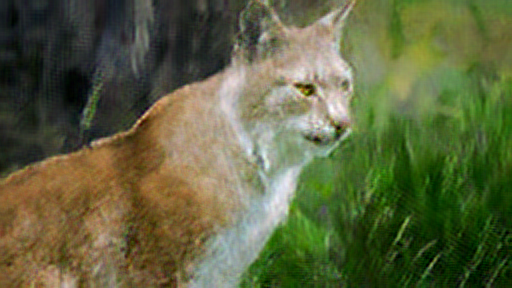

In [8]:
def toimg(x) -> Image.Image:
    if len(x.shape) == 4 and x.shape[0] == 1:
        x = x.view(x.shape[1:])
    return transforms.ToPILImage()(denormalize(x).clamp_(0.0, 1.0))


a = vid_ds[1].to(dev)
a = a.view((1,) + a.shape)
a = net(a)
a = a.view(a.shape[1:])
print(a.shape)
toimg(a)


In [8]:
import os

output_dir = R"C:\Programs\EbSynth-Beta-Win\SampleProject - Copy\temp2"

net.eval()
for i, a in enumerate(iter(vid_ds)):
    a = a.to(dev)
    a = a.view((1,) + a.shape)
    a = net(a)
    a = toimg(a)
    a.save(f"{output_dir}/{i:05d}.png")